In [1]:
import pandas as pd
import torch

import os, sys

import torch.nn.functional
import torch.nn.functional as F

project_root = os.path.abspath('/Users/subhojit/workspace/saturn/src')
if project_root not in sys.path:
    sys.path.append(project_root)

from lstm_att.lstm_multiplicative_att import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_dir = '/Users/subhojit/datasets/cmu_pronouncing_dict'
dict_file = open(dataset_dir + '/cmudict.dict', 'r')

words = []
phonics_list = []
with dict_file as f:
    for line in f:
        phonics = line.rstrip('\n').split(" ")
        words.append(phonics[0])
        phonics_list.append(' '.join(phonics[1:]))

data = pd.DataFrame({'words': words, 'phonics': phonics_list})
data.head()


,words,phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


In [3]:
df = data.sample(data.shape[0]).reset_index(drop=True)
df

,words,phonics
0,dramatizations,D R AE2 M AH0 T AH0 Z EY1 SH AH0 N Z
1,leath's,L IY1 TH S
2,bietz,B IY1 T S
3,rasnick,R AE1 S N IH0 K
4,cotton's,K AA1 T AH0 N Z
...,...,...
135005,henne,HH EH1 N
135006,trippel,T R IH1 P AH0 L
135007,additives(2),AE1 D IH0 T IH0 V Z
135008,willamina,W IH0 L AH0 M AY1 N AH0


In [4]:
df[~df['words'].apply(lambda x: x.isalnum())]

,words,phonics
1,leath's,L IY1 TH S
4,cotton's,K AA1 T AH0 N Z
12,strieker's,S T R IY1 K ER0 Z
28,kobe's,K OW1 B EY0 Z
30,saddam(2),S AH0 D AA1 M
...,...,...
134971,earpieces(2),IY1 R P IY0 S IH0 Z
134980,farmers',F AA1 R M ER0 Z
134992,cache(2),K AE0 SH EY1
135001,directory(4),D IH0 R EH1 K T ER0 IY0


In [5]:
df['phonics'] = '<sos> ' + df['phonics'] + ' <eos>'
df.head()

,words,phonics
0,dramatizations,<sos> D R AE2 M AH0 T AH0 Z EY1 SH AH0 N Z <eos>
1,leath's,<sos> L IY1 TH S <eos>
2,bietz,<sos> B IY1 T S <eos>
3,rasnick,<sos> R AE1 S N IH0 K <eos>
4,cotton's,<sos> K AA1 T AH0 N Z <eos>


In [6]:
words = df['words'].tolist()
phonics = df['phonics'].tolist()

In [7]:
words[:10] , phonics[:10]

(['dramatizations',
  "leath's",
  'bietz',
  'rasnick',
  "cotton's",
  'irregulars',
  'euchred',
  'treasonous',
  'compiler',
  'serfs'],
 ['<sos> D R AE2 M AH0 T AH0 Z EY1 SH AH0 N Z <eos>',
  '<sos> L IY1 TH S <eos>',
  '<sos> B IY1 T S <eos>',
  '<sos> R AE1 S N IH0 K <eos>',
  '<sos> K AA1 T AH0 N Z <eos>',
  '<sos> IH2 R EH1 G Y AH0 L ER0 Z <eos>',
  '<sos> Y UW1 K ER0 D <eos>',
  '<sos> T R IY1 Z AH0 N AH2 S <eos>',
  '<sos> K AH0 M P AY1 L ER0 <eos>',
  '<sos> S ER1 F S <eos>'])

In [8]:
words = [w.lower() for w in words]
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi['<pad>'] = 0
vocab_size = len(stoi)
encode = lambda s: [stoi[ch] for ch in s.lower()]

encode('Adhasdja1wasj')


[10, 13, 17, 10, 28, 13, 19, 10, 6, 32, 10, 28, 19]

In [9]:
import numpy as np
target_seq = [p.split(' ') for p in phonics]
target_seq = [item for nested_list in target_seq for item in nested_list]
target_seq = list(set(target_seq))
phoneme_vocab_size = len(target_seq)

ptoi = {ph: i for i, ph in enumerate(target_seq)}
encode_p = lambda p: ptoi[p]
encode_phonemes = lambda p: [ptoi[ph] for ph in p]

encode_phonemes(['ER0']), encode_p('ER0')


([34], 34)

In [10]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtrain = words[:n1]
ytrain = phonics[:n1]
xval = words[n1:n2]
yval = phonics[n1:n2]
xtest = words[n2:]
ytest = phonics[n2:]

# xtrain = torch.tensor([encode(x) for x in xtrain], dtype=torch.long)
# ytrain = torch.tensor([encode_phonemes(ph) for ph in ytrain], dtype=torch.long)
# xval = torch.tensor([encode(x) for x in xval], dtype=torch.long)
# yval = torch.tensor([encode_phonemes(ph) for ph in yval], dtype=torch.long)
# xtest = torch.tensor([encode(x) for x in xtest], dtype=torch.long)
# ytest = torch.tensor([encode_phonemes(ph) for ph in ytest], dtype=torch.long)


In [11]:
def pad_sequences(sequences):
    pad_index = stoi['<pad>']
    max_len = np.max([len(s) for s in sequences])
    lenghts = torch.zeros(len(sequences), dtype=torch.long)
    padded_seq = torch.zeros(len(sequences), max_len, dtype=torch.long)
    for i, seq in enumerate(sequences):
        padded_seq[i, :len(seq)] = torch.tensor(seq)
        lenghts[i] = len(seq)
    return padded_seq, lenghts

def get_batch(batch_size, split='train'):
    x, y = {
        'train': (xtrain, ytrain),
        'val': (xval, yval),
        'test': (xtest, ytest)
    }[split]
    # x = xtrain if split == 'train' else xval
    # y = ytrain if split == 'train' else yval
    idx = torch.randint(0, len(x), (batch_size,))
    xb = [encode(x[i]) for i in idx]
    yidx = [y[i] for i in idx]
    phoneme_sequences = [encode_phonemes(p.split(' ')) for p in yidx]
    yb, p_lengths = pad_sequences(phoneme_sequences)
    xb, lengths = pad_sequences(xb)
    return xb, yb, lengths, p_lengths


get_batch(10)



(tensor([[16, 27, 10, 22, 11, 21, 18, 23, 16,  0,  0],
         [10, 23, 23, 14, 29, 29,  0,  0,  0,  0,  0],
         [27, 14, 18, 12, 17, 17, 24, 21, 13,  1, 28],
         [27, 14, 11, 14, 21, 24,  0,  0,  0,  0,  0],
         [13, 27, 18, 23, 20, 10, 11, 21, 14,  0,  0],
         [32, 18, 12, 14,  0,  0,  0,  0,  0,  0,  0],
         [11, 30, 27, 29, 24, 23,  0,  0,  0,  0,  0],
         [20, 10, 27, 25, 15,  0,  0,  0,  0,  0,  0],
         [22, 10, 27, 20, 18, 14,  0,  0,  0,  0,  0],
         [12, 27, 18, 28, 17, 22, 10, 23,  0,  0,  0]]),
 tensor([[30, 29, 14,  8,  2, 23, 19, 74, 25, 18,  0],
         [30, 63, 55, 27, 76, 18,  0,  0,  0,  0,  0],
         [30, 14, 20, 59, 65,  7, 19,  5, 70, 18,  0],
         [30, 14, 13, 23, 27, 19, 32, 18,  0,  0,  0],
         [30,  5, 14, 66, 55, 59, 63, 23, 63, 19, 18],
         [30, 72, 20, 52, 18,  0,  0,  0,  0,  0,  0],
         [30, 23, 57, 76, 63, 55, 18,  0,  0,  0,  0],
         [30, 59, 39, 14, 43, 28, 18,  0,  0,  0,  0],
        

In [12]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [13]:
# training with LSTM with multiplicative attention
embedding_dim = 32
hidden_size = 64
output_size = 2
attention_dim = 64
batch_size = 64
seq_len = 10
learning_rate = 1e-3
max_iter = 5000
eval_interval = 500


In [14]:
# 1-batch overfitting
model = EncoderDecoderLSTMWithMA(vocab_size, hidden_size, phoneme_vocab_size, embedding_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

xb, yb, lengths, p_lengths = get_batch(10)
xb, yb, lengths, p_lengths = xb.to(device), yb.to(device), lengths.to(device), p_lengths.to(device)

for step in range(1000):
    logits = model(xb, lengths, yb, p_lengths)
    B, T, V = logits.shape
    logits = logits.view(B*T, V)
    yb_mod = yb.view(B*T)
    loss = F.cross_entropy(logits, yb_mod)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"step: {step}, loss: {loss.item():.4f}")

step: 0, loss: 4.3758
step: 1, loss: 4.3519
step: 2, loss: 4.3278
step: 3, loss: 4.3030
step: 4, loss: 4.2772
step: 5, loss: 4.2501
step: 6, loss: 4.2210
step: 7, loss: 4.1894
step: 8, loss: 4.1545
step: 9, loss: 4.1152
step: 10, loss: 4.0704
step: 11, loss: 4.0183
step: 12, loss: 3.9570
step: 13, loss: 3.8839
step: 14, loss: 3.7969
step: 15, loss: 3.6948
step: 16, loss: 3.5791
step: 17, loss: 3.4555
step: 18, loss: 3.3326
step: 19, loss: 3.2186
step: 20, loss: 3.1187
step: 21, loss: 3.0344
step: 22, loss: 2.9647
step: 23, loss: 2.9072
step: 24, loss: 2.8588
step: 25, loss: 2.8167
step: 26, loss: 2.7781
step: 27, loss: 2.7406
step: 28, loss: 2.7020
step: 29, loss: 2.6609
step: 30, loss: 2.6162
step: 31, loss: 2.5675
step: 32, loss: 2.5163
step: 33, loss: 2.4664
step: 34, loss: 2.4215
step: 35, loss: 2.3831
step: 36, loss: 2.3487
step: 37, loss: 2.3151
step: 38, loss: 2.2801
step: 39, loss: 2.2430
step: 40, loss: 2.2048
step: 41, loss: 2.1669
step: 42, loss: 2.1305
step: 43, loss: 2.096

In [15]:

# training loop
model = EncoderDecoderLSTMWithMA(vocab_size, hidden_size, phoneme_vocab_size, embedding_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for step in range(max_iter):
    xb, yb, lengths, p_lengths = get_batch(batch_size)
    xb, yb, lengths, p_lengths = xb.to(device), yb.to(device), lengths.to(device), p_lengths.to(device)

    logits = model(xb, lengths, yb, p_lengths)

    B, T, V = logits.shape
    logits = logits.view(B*T, V)
    yb_mod = yb.view(B*T)
    loss = F.cross_entropy(logits, yb_mod)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"step: {step}, loss: {loss.item():.4f}")

step: 0, loss: 4.3422
step: 100, loss: 1.2428
step: 200, loss: 0.2845
step: 300, loss: 0.0815
step: 400, loss: 0.0465
step: 500, loss: 0.0345
step: 600, loss: 0.0179
step: 700, loss: 0.0136
step: 800, loss: 0.0166
step: 900, loss: 0.0091
step: 1000, loss: 0.0075
step: 1100, loss: 0.0054
step: 1200, loss: 0.0048
step: 1300, loss: 0.0039
step: 1400, loss: 0.0029
step: 1500, loss: 0.0034
step: 1600, loss: 0.0046
step: 1700, loss: 0.0024
step: 1800, loss: 0.0019
step: 1900, loss: 0.0018
step: 2000, loss: 0.0018
step: 2100, loss: 0.0014
step: 2200, loss: 0.0014
step: 2300, loss: 0.0010
step: 2400, loss: 0.0010
step: 2500, loss: 0.0009
step: 2600, loss: 0.0009
step: 2700, loss: 0.0008
step: 2800, loss: 0.0008
step: 2900, loss: 0.0007
step: 3000, loss: 0.0007
step: 3100, loss: 0.0007
step: 3200, loss: 0.0006
step: 3300, loss: 0.0006
step: 3400, loss: 0.0004
step: 3500, loss: 0.0004
step: 3600, loss: 0.0004
step: 3700, loss: 0.0004
step: 3800, loss: 0.0004
step: 3900, loss: 0.0004
step: 4000, 

In [ ]:
def get_validation_batch(batch_size, split='val'):
    x, y = {
        'train': (xtrain, ytrain),
        'val': (xval, yval),
        'test': (xtest, ytest)
    }[split]

    iter_size = len(x) // batch_size
    for i in range(iter_size):
        idx = torch.arange(i*batch_size, i*batch_size + batch_size)
        xb = [encode(x[i]) for i in idx]
        yidx = [y[i] for i in idx]
        phoneme_sequences = [encode_phonemes(p.split(' ')) for p in yidx]
        yb, p_lengths = pad_sequences(phoneme_sequences)
        xb, lengths = pad_sequences(xb)
        yield xb, yb, lengths, p_lengths

def compute_accuracy():
    pad_index = stoi['<pad>']
    correct = 0
    total = 0
    for xb, yb, lengths, p_lengths in get_validation_batch(batch_size, 'val'):
        xb, yb, lengths, p_lengths = xb.to(device), yb.to(device), lengths.to(device), p_lengths.to(device)
        logits = model(xb, lengths, yb, p_lengths)
        preds = torch.argmax(logits, dim=2)
        print(f"Preds:    ", preds)
        print(f"Targets:  ", yb)
        match = (preds == yb) | (yb == pad_index)  # ignore padding
        sequence_match = match.all(dim=1)          # all tokens in the row must match
        correct += sequence_match.sum().item()
        total += sequence_match.size(0)

    accuracy = (correct / total) * 100
    print(f"Accuracy: {accuracy:.4f}")


val_acc = compute_accuracy()

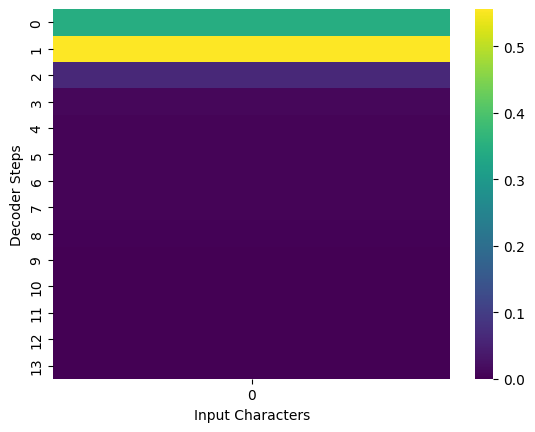

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
a = model.decoder.aw[0].unsqueeze(1)
sns.heatmap(a.detach().cpu().numpy(), cmap="viridis")
plt.xlabel("Input Characters")
plt.ylabel("Decoder Steps")
plt.show()